In [63]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

View the data:

In [2]:
data = pd.read_csv("./Data/Project2_Train.csv")
test = pd.read_csv("./Data/Project2_Test.csv")
data.head()

,id,Gender,Age,Region_Code,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,Response
0,319654,Male,22,46,< 1 Year,Yes,29719,79,0
1,298528,Female,40,28,1-2 Year,Yes,29645,99,0
2,120858,Male,25,28,1-2 Year,Yes,35996,266,1
3,234326,Female,25,29,< 1 Year,No,56899,25,0
4,372307,Female,70,28,1-2 Year,No,47452,189,0


Preparing the data:

In [3]:
def format_data(data):
    train = data.copy()

    # Gender binary encoding
    train["Is_Male"] = (train["Gender"] == "Male").astype(int)

    # Region_Code dummy variables
    Region_Code_vals = sorted(train["Region_Code"].unique())
    Region_Code_cols = []
    for i in Region_Code_vals:
        colname = "Region_Code_" + str(i)
        Region_Code_cols.append(colname)
        train[colname] = (train["Region_Code"] == i).astype(int)

    # Vehicle_Age ordinal
    one_to_two = train["Vehicle_Age"] == "1-2 Year"
    more_than_two = train["Vehicle_Age"] == "> 2 Years"
    train["Vehicle_Age_Ordinal"] = 1
    train.loc[one_to_two, "Vehicle_Age_Ordinal"] = 2
    train.loc[more_than_two, "Vehicle_Age_Ordinal"] = 3

    # Vehicle_Damage binary encoding
    train["Vehicle_Not_Damaged"] = (train["Vehicle_Damage"] == "No").astype(int)
    relevant_cols = ["Is_Male"] + Region_Code_cols[:-1] + ["Vehicle_Age_Ordinal", "Vehicle_Not_Damaged", 
                                                           "Annual_Premium", "Vintage", "Response"]
    return(train[relevant_cols])

data_formatted = format_data(data)
data_formatted.head()

,Is_Male,Region_Code_3,Region_Code_8,Region_Code_11,Region_Code_15,Region_Code_28,Region_Code_29,Region_Code_30,Region_Code_41,Region_Code_46,Vehicle_Age_Ordinal,Vehicle_Not_Damaged,Annual_Premium,Vintage,Response
0,1,0,0,0,0,0,0,0,0,1,1,0,29719,79,0
1,0,0,0,0,0,1,0,0,0,0,2,0,29645,99,0
2,1,0,0,0,0,1,0,0,0,0,2,0,35996,266,1
3,0,0,0,0,0,0,1,0,0,0,1,1,56899,25,0
4,0,0,0,0,0,1,0,0,0,0,2,1,47452,189,0


In [99]:
def format_data(data):
    data = data.copy()
    le = LabelEncoder()

    # Integer Encoding
    data["Vehicle_Age"] = le.fit_transform(data["Vehicle_Age"]) # 1-2 year = 0, < 1 year = 1, > 2 year = 2

    # Dummy Encoding 
    # Vehicle_Age - VA, Region_Code - RC, Vehicle_Damage - VD
    data = pd.get_dummies(data,columns=["Region_Code","Gender","Vehicle_Damage"], 
                            prefix=["RC","Gender","VD"], drop_first=True)

    # Split into train 
    y_train = data.loc[:, 'Response']
    X_train = data.drop('Response', 1)

    return X_train, y_train

X_train, y_train = format_data(data)
X_train.head()

,id,Age,Vehicle_Age,Annual_Premium,Vintage,RC_8,RC_11,RC_15,RC_28,RC_29,RC_30,RC_41,RC_46,RC_50,Gender_Male,VD_Yes
0,319654,22,1,29719,79,0,0,0,0,0,0,0,1,0,1,1
1,298528,40,0,29645,99,0,0,0,1,0,0,0,0,0,0,1
2,120858,25,0,35996,266,0,0,0,1,0,0,0,0,0,1,1
3,234326,25,1,56899,25,0,0,0,0,1,0,0,0,0,0,0
4,372307,70,0,47452,189,0,0,0,1,0,0,0,0,0,0,0


Split the data:

In [86]:
Region_Code_cols = []
for col in data_formatted.columns:
    if "Region_Code_" in col:
        Region_Code_cols.append(col)

# The last col of region code is left out due to how dummy encoding works
X_cols = ["Is_Male"] + Region_Code_cols[:-1] + ["Vehicle_Age_Ordinal", "Vehicle_Not_Damaged", "Annual_Premium", "Vintage"]
X = data_formatted.loc[:, X_cols]
y = data_formatted.loc[:, "Response"]

# Getting test and train set
SEED = 1

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=SEED)
X_train.head()

,Is_Male,Region_Code_3,Region_Code_8,Region_Code_11,Region_Code_15,Region_Code_28,Region_Code_29,Region_Code_30,Region_Code_41,Vehicle_Age_Ordinal,Vehicle_Not_Damaged,Annual_Premium,Vintage
629,0,0,0,0,0,1,0,0,0,2,1,2630,100
8182,1,0,0,0,0,0,0,0,0,1,0,34001,20
81,1,0,0,0,0,1,0,0,0,2,1,42754,28
6232,1,0,0,0,0,1,0,0,0,2,0,52979,154
5604,0,1,0,0,0,0,0,0,0,1,1,22629,163


Fit the random tree:

In [100]:
rf_class = RandomForestClassifier(n_estimators=400, random_state=SEED)

param_grid = {"max_depth": np.arange(2, 5), 
                "min_samples_leaf": [5, 10, 25, 50]} 

grid_rf_class = GridSearchCV(
        estimator = rf_class,
        param_grid = param_grid,
        scoring = "roc_auc",
        n_jobs = 2,
        cv = 5,
        refit = True,
        return_train_score = True
)

grid_rf_class.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=400, random_state=1),
             n_jobs=2,
             param_grid={'max_depth': array([2, 3, 4]),
                         'min_samples_leaf': [5, 10, 25, 50]},
             return_train_score=True, scoring='roc_auc')

Evaluate:

In [101]:
print(grid_rf_class.best_score_)
print(grid_rf_class.best_params_)

0.8219959949004222
{'max_depth': 4, 'min_samples_leaf': 50}


In [103]:
y_pred = grid_rf_class.predict(X_test)
roc_auc_score(y_test, y_pred)

0.5

Get feature importance:

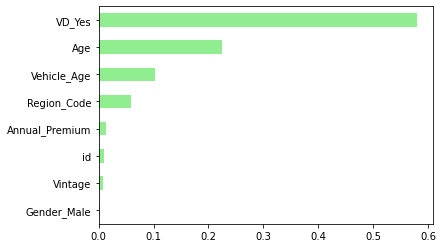

In [105]:
importances_rf = pd.Series(grid_rf_class.best_estimator_.feature_importances_, index=X.columns)

# Colapse region code factors
Region_Code_val = sum(importances_rf.loc[[col for col in X.columns if "Region_Code_" in col]])
importances_rf = importances_rf.loc[[col for col in X.columns if "Region_Code_" not in col]]
importances_rf.loc["Region_Code"] = Region_Code_val

sorted_importances_rf = importances_rf.sort_values()

# Horizontal bar plot
sorted_importances_rf.plot(kind="barh", color="lightgreen")
plt.show()